# Import the data and libraries <a name='bookmark0' />
- Scraped rental data from domain
- Historical (median) rental data (because unemployment data is a time series with only ONE attribute)
- unemployment data

In [1]:
import geopandas as gpd
import pandas as pd
import ast #can make use of ast.literal_eval(string_rep_of_list) to convert string repr of list to actual list object
from shapely.geometry import Point
import folium
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt #to find centroid of a polygon
import difflib
import seaborn as sns
from pandas.plotting import parallel_coordinates

Self-Note: previously the raw (briefly preprocessed) historical rental data was named <code>Monthly_Median_Suburb_Rents.csv</code>

However it was changed it to <code>Fixed_Weekly_Median_Suburb_Rents.csv</code> and the *full* preprocessed historical rental data will be of the same name (that is, <code>Fixed_Weekly_Median_Suburb_Rents.csv</code>)

In [2]:
unemp_data = pd.read_csv('../data/curated/Preproc_Unemployment_Data.csv').drop(columns=['Unnamed: 0'])
unemp_data = unemp_data.dropna(how = 'any')

historical_rental_data = pd.read_csv('../data/curated/Fixed_Weekly_Median_Suburb_Rents.csv').drop(columns=['Unnamed: 0'])

# First, we have to preprocess the historical rental data and unemployment data in a way that is suitable for graphical preliminary analysis.

In [3]:
def fix_suburb_names_in_lookup_data():
    
    """Preprocessing the victorian states lookup data.
    This will ultimately help to filter out or rename
    suburb names in the unemployment and/or historical
    rental data """
    #PREPROCESSING THE VICTORIAN STATES LOOKUP DATA
    #import first
    suburb_state_lookup = pd.read_csv('../data/raw/georef-australia-state-suburb.zip')
    suburb_state_lookup = suburb_state_lookup[
        suburb_state_lookup['Official Name State'] == 'Victoria'
    ]


    #fixing problematic suburb names: some suburbs have the form 'SUBURB (REGION - Vic.)'
    suburb_lookup_contain_nonalphas_matches = suburb_state_lookup['Official Name Suburb'].sort_values().\
    str.findall('[^A-Za-z\s].*[^A-Za-z\s]')

    #note i extract first element/match only, given that ive checked 
    #that re.findall only returns at most 1 match
    nonalpha_chars_in_suburbs = suburb_lookup_contain_nonalphas_matches[
        suburb_lookup_contain_nonalphas_matches.map(lambda x: bool(x))
    ].map(lambda x: x[0]) 

    #obtain SUBURB in all suburbs of the form  'SUBURB (REGION - Vic.)'
    nonalpha_suburbs_fixed = suburb_state_lookup['Official Name Suburb'].\
                loc[nonalpha_chars_in_suburbs.index].\
                str.findall('([A-Za-z][A-Za-z\s]*[A-Za-z])').\
                map(lambda x: x[0]).\
                str.strip()

    #then propagate the change to the original lookup data
    suburb_state_lookup['Official Name Suburb'].\
                loc[nonalpha_chars_in_suburbs.index] = nonalpha_suburbs_fixed

    #also, 'Murray-Sunset' is not a suburb. So delete it
    suburb_state_lookup['Official Name Suburb'] = suburb_state_lookup['Official Name Suburb'][
        suburb_state_lookup['Official Name Suburb'] != 'Murray-sunset'
    ]

    return suburb_state_lookup


In [4]:
def fix_suburb_names_in_historical_rental_data(historical_rental_data):
    
    """
    Fix suburb names in the historical rental data 
    that contain non-alphabetic chars and/or unusual
    naming conventions. 
    
    Will be split into 3 sections I, II, III 
    
    """
    
    
    #I. Split SA2s that encompass more than 1 suburb, usually indicated by '-'
    
    #BUT those of the form SUBURB - DIRECTION (DIRECTION e.g. north, east, etc)
    #are SA2s that only encompass a *part* of a suburb
    #Note: $ is a metacharacter in regex, stating the end of the string
    SA2s_rental_w_multiple_suburbs = historical_rental_data['Suburb'][
        (historical_rental_data['Suburb'].str.contains('-')) & 
        ~(historical_rental_data['Suburb'].str.contains('- North$')) &
        ~(historical_rental_data['Suburb'].str.contains('- South$')) &
        ~(historical_rental_data['Suburb'].str.contains('- East$')) &
        ~(historical_rental_data['Suburb'].str.contains('- West$')) 
    ]

    #split the suburbs in each SA2 to individual suburbs 
    SA2s_rental_w_multiple_suburbs = SA2s_rental_w_multiple_suburbs.str.split(r'\s*-\s*')


    #create empty dataframe with empty columns, for storing instances where SA2s 
    #comprised of multiple suburbs
    rental_data_SA2s_w_multiple_suburbs = pd.DataFrame(columns=historical_rental_data.columns)

    #extract the indexes
    SA2s_rental_w_multiple_suburbs_index = SA2s_rental_w_multiple_suburbs.index

    #iterator variable for obtaining indexes of instances for which SA2s are 
    #located in SA2s_unemp_data_w_multiple_suburbs
    i = 0 

    for multiple_suburbs_in_a_SA2 in SA2s_rental_w_multiple_suburbs:

        #extract the corresponding index, so that we can modify the instance later
        idx = SA2s_rental_w_multiple_suburbs_index[i]


        #for each individual suburb in the SA2
        for individual_suburb in multiple_suburbs_in_a_SA2:

            #extract instance where its SA2 corresponding 
            #to multiple_suburbs_in_a_SA2
            inst = historical_rental_data.loc[idx,:]

            #modify the SA2_Name, that contain multiple_suburbs_in_a_SA2,  
            #into the individual suburb "individual_suburb"

            inst['Suburb'] = individual_suburb

            #stack the row "inst" into unemp_data_SA2s_w_multiple_suburbs
            rental_data_SA2s_w_multiple_suburbs =\
                pd.concat([
                    pd.DataFrame([inst],columns=historical_rental_data.columns), 
                    rental_data_SA2s_w_multiple_suburbs
                  ],
                  axis=0)


        i += 1


    rental_data_no_SA2_w_mult_subs = historical_rental_data[~historical_rental_data.index.\
                                                            isin(SA2s_rental_w_multiple_suburbs.index)].\
    copy()

    rental_data_all_suburb = pd.concat([rental_data_no_SA2_w_mult_subs,
               rental_data_SA2s_w_multiple_suburbs],
              axis=0)


    #II. retain observations in 4th quarter of rental data
    
    rental_data_all_suburb = rental_data_all_suburb[
        rental_data_all_suburb['Quarter'] == 4
    ]

    #III. as a result of collapsing subrubs (or sa2s, rather) with dashes, 
    #we have to make sure that all of them are indeed suburbs. Otherwise
    #if we can fix their namings, we fix them. 

    #obtain all subrubs that are not in the lookup data 
    #these are listed in 'suburbs_before_fixed' var below

    #Before that, remove obvious non-suburbs in rental data
    rental_data_all_suburb = rental_data_all_suburb[
        ~rental_data_all_suburb['Suburb'].isin(['Yarra Ranges', 'St Kilda Rd', 'CBD'])
    ]


    #do fuzzy string matching between suburbs (that dont exist in lookup  data)
    #to suburbs in lookup data. This is the result (code for fuzzy string matching not included)
    suburbs_before_fixed = ['East St Kilda','East Hawthorn', 'East Brunswick','Ballarat',
     'Wanagaratta',
     'Bendigo East',
     'West St Kilda',
     'Mt Eliza',
     'Newcombe',
     'West Brunswick',
     'Mt Martha']


    suburbs_fixed = ['St Kilda', 'Hawthorn East', 
                     'Brunswick', 'Ballarat East', 'Wangaratta',
                    'Bendigo', 'St Kilda West', 'Mount Eliza',
                    'Newcomb', 'Brunswick West', 'Mount Martha']

    fix_ambiguous_rental_suburbs = dict(zip(suburbs_before_fixed, suburbs_fixed))

    #not all suburbs need fixing. So other "safe" suburbs can just stay as they are!
    def fix_ambiguous_suburbs_rental(suburb):
        """For the ambiguous suburbs above, map them to the
        correct ones (in the rental data)"""

        if suburb not in fix_ambiguous_rental_suburbs:
            return suburb
        else: 
            return fix_ambiguous_rental_suburbs[suburb]

    #fix the ambiguous suburbs 
    rental_data_all_suburb['Suburb'] = rental_data_all_suburb['Suburb'].map(
        lambda suburb: fix_ambiguous_suburbs_rental(suburb))
    
    #lastly, casefold all suburb names into lower case.
    rental_data_all_suburb['Suburb'] = rental_data_all_suburb['Suburb'].\
                            str.lower()

    return rental_data_all_suburb

## Justification for III. below

Even if those "partial" suburbs exist in the rental data, how are we going to aggregate, say, unemployment rate of <code> St Albans - North, St Albans - South</code>? 
- Surely not by addition because it doesn't make sense to add proportions

- Also, by the SA2 documentation here https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/main-structure-and-greater-capital-city-statistical-areas/statistical-area-level-2, *Where a single large suburb is split into more than one SA2, it will retain the name of the suburb and a geographic identifier, for example “Mount Waverley – North”.*
    - Unemployment rate from one portion of the suburb probably won't be representative of the whole suburb, since the whole suburb, as mentioned, is relatively large.

In [5]:
def further_preprocess_unemp_data(unemp_data):
    
    
    """
    Further preprocess the unemployment data in a way
    that is feasible to be joined with the historical rental data
    
    Will be split into 7 sections. 
    
    """

    ## I. COLLAPSE SA2S COMPRISING OF MULTIPLE SUBURBS 
    ## INTO INDIVIDUAL SUBURBS. 
    ## THESE SUBURBS ARE SEPARATED BY DASHES BUT THEY 
    ## MUST NOT CONTAIN ANY DIRECTIONS (E.G. NORTH) BECAUSE
    ## THOSE ARE SA2S THAT ONLY COMPRISE ONE PART OF A SUBURB
    
    #Note: $ is a metacharacter in regex, stating the end
    SA2s_unemp_data_w_multiple_suburbs = unemp_data['SA2_Name'][
        (unemp_data['SA2_Name'].str.contains('-')) & 
        ~(unemp_data['SA2_Name'].str.contains('- North$')) &
        ~(unemp_data['SA2_Name'].str.contains('- South$')) &
        ~(unemp_data['SA2_Name'].str.contains('- East$')) &
        ~(unemp_data['SA2_Name'].str.contains('- West$')) 
    ]

    #split the suburbs in each SA2 to individual suburbs 
    SA2s_unemp_data_w_multiple_suburbs = SA2s_unemp_data_w_multiple_suburbs.str.split(r'\s*-\s*')

    
    #create empty dataframe with empty columns, for storing instances where SA2s 
    #comprised of multiple suburbs
    unemp_data_SA2s_w_multiple_suburbs = pd.DataFrame(columns=unemp_data.columns)

    #extract the indexes
    SA2s_unemp_data_w_multiple_suburbs_index = SA2s_unemp_data_w_multiple_suburbs.index

    #iterator variable for obtaining indexes of instances for which SA2s are 
    #located in SA2s_unemp_data_w_multiple_suburbs
    i = 0 

    for multiple_suburbs_in_a_SA2 in SA2s_unemp_data_w_multiple_suburbs:

        #extract the corresponding index, so that we can modify the instance later
        idx = SA2s_unemp_data_w_multiple_suburbs_index[i]


        #for each individual suburb in the SA2
        for individual_suburb in multiple_suburbs_in_a_SA2:

            #extract instance where its SA2 corresponding 
            #to multiple_suburbs_in_a_SA2
            inst = unemp_data.loc[idx,:]

            #modify the SA2_Name, that contain multiple_suburbs_in_a_SA2,  
            #into the individual suburb "individual_suburb"

            inst['SA2_Name'] = individual_suburb

            #stack the row "inst" into unemp_data_SA2s_w_multiple_suburbs
            unemp_data_SA2s_w_multiple_suburbs =\
                pd.concat([
                    pd.DataFrame([inst],columns=unemp_data.columns), 
                    unemp_data_SA2s_w_multiple_suburbs
                  ],
                  axis=0)


        i += 1
        
    
    
    unemp_data_no_SA2_w_mult_subs = unemp_data[~unemp_data.index.\
                                     isin(SA2s_unemp_data_w_multiple_suburbs_index)].\
                                    copy()
    
    unemp_data_all_suburb = pd.concat([unemp_data_no_SA2_w_mult_subs,
           unemp_data_SA2s_w_multiple_suburbs],
          axis=0)
    
    
    ## II. AS FOR SUBURBS THAT ARE NOT PART OF THOSE SPECIFIED IN 
    ## PART I., MAKE SURE THEIR NAMINGS ARE PROPER. 
    
    unemp_regions_no_dash = unemp_data_all_suburb['SA2_Name'][
        ~unemp_data_all_suburb['SA2_Name'].str.contains('-')
    ]
    
    
    #for suburbs that are followed by '(Vic. )', remove the
    #'(Vic. )'
    
    unemp_regions_no_dash[
        unemp_regions_no_dash.str.contains('[^A-Za-z\s].*[^A-Za-z\s]')
    ] =\
        unemp_regions_no_dash[
            unemp_regions_no_dash.str.contains('[^A-Za-z\s].*[^A-Za-z\s]')
        ].str.findall('([A-Za-z][A-Za-z\s]*[A-Za-z])').map(lambda x:x[0])
    
    #make changes permanently to the preprocessed data so far.
    unemp_data_all_suburb['SA2_Name'][
        ~unemp_data_all_suburb['SA2_Name'].str.contains('-')
    ] = unemp_regions_no_dash
    
    
        
    ## III. NOW, WE STILL HAVE SA2S CONTAINING '-' THAT
    ## ENCOMPASS PART OF A SUBURB. BUT WE STILL CAN REMOVE 
    ## THEM FOR THE REASON IN THE MARKDOWN CELL ABOVE.
    
    unemp_data_all_suburb = unemp_data_all_suburb[
        ~unemp_data_all_suburb['SA2_Name'].str.contains('-')
    ]
    
    ## IV. REFORMAT THE DATA: MELT ALL THE YEARS (WHICH WAS
    ## PREVIOUSLY IN COLUMNS) INTO VALUES STORED IN A 
    ## YEAR COLUMN
    
    unemp_data_all_suburb_melted = pd.melt(unemp_data_all_suburb, 
        id_vars = ['SA2_Name', 'SA2_Code'],
        value_vars = unemp_data_all_suburb.columns[2:]
    )
    
    unemp_data_all_suburb_melted.columns = ['suburb', 'sa2_code', 
                                            'quarter-year', 'unemp_rate']
    
    #split month-year pairs into month, year (2 columns)
    quarter_year_pairs = unemp_data_all_suburb_melted['quarter-year'].str.split('-',2,expand=True)
    quarter_year_pairs.columns = ['quarter','year']
    
    #prepend '20' to each year, since years are only last 2 digits 
    quarter_year_pairs['year'] = quarter_year_pairs['year'].map(lambda s: '20'+s)
    
    #Add the parsed month-year pairs back to original data
    unemp_data_all_suburb_melted = pd.concat([unemp_data_all_suburb_melted, 
                                              quarter_year_pairs],axis=1)
    
    #remove the original quarter-year pair
    unemp_data_all_suburb_melted = unemp_data_all_suburb_melted.drop(columns=['quarter-year'])
    
    
    ## V. ONLY RETAIN OBSERVATIONS FROM FOURTH QUARTERS 
    ## OF EACH YEAR
    
    unemp_data_all_suburb_melted = unemp_data_all_suburb_melted[
        unemp_data_all_suburb_melted['quarter'] == 'Dec'
    ]

    unemp_data_all_suburb_melted = unemp_data_all_suburb_melted.drop(columns=['quarter'])
    
    ## VI. RENAME SUBURBS THAT ARE NOT INCONSISTENT
    ## WITH THE SUBURB LOOKUP DATA AS REFERENCE
    
    #after careful inspections, these are not actual suburbs so can drop them
    unemp_ambiguous_suburbs_to_drop = ['Central', 'Point Nepean', 'Yarra Valley', 'Loddon', 'Glenelg',
        'Buloke', 'Wandin', 'Yarriambiack', 'Seymour Region', 'Southern Grampians',
        'Mount Baw Baw Region', 'Phillip Island', 'Nhill Region', 'Moira',
        'West Wimmera', 'Otway']
    
    unemp_data_all_suburb_melted = unemp_data_all_suburb_melted[
        ~unemp_data_all_suburb_melted['suburb'].isin(unemp_ambiguous_suburbs_to_drop)
    ]
    
    #these are the suburbs that need renaming. 
    suburbs_before_fixed_unemp = ['Maryborough Region', 'Ballarat','Bacchus Marsh Region',
         'Colac Region','Horsham Region','Swan Hill Region','Mildura Region',
        'Ararat Region', 'Wangaratta Region','Benalla Region','Castlemaine Region']


    suburbs_fixed_unemp = ['Maryborough', 'Ballarat East', 'Bacchus Marsh',
                    'Colac Colac', 'Horsham', 'Swan Hill', 'Mildura',
                    'Ararat', 'Wangaratta', 'Benalla', 'Castlemaine']
    
    fix_ambiguous_unemp_suburbs = dict(zip(suburbs_before_fixed_unemp, suburbs_fixed_unemp))
    
    
    #not all suburbs need fixing. So other "safe" suburbs can just stay as they are!
    def fix_ambiguous_suburbs_unemp(suburb):
        """For the ambiguous suburbs above, map them to the
        correct ones (in the unemployment data)"""

        if suburb not in fix_ambiguous_unemp_suburbs:
            return suburb
        else: 
            return fix_ambiguous_unemp_suburbs[suburb]

    #fix the ambiguous suburbs 
    unemp_data_all_suburb_melted['suburb'] = unemp_data_all_suburb_melted['suburb'].map(
        lambda suburb: fix_ambiguous_suburbs_unemp(suburb))
    
    
    ## VII. FINALLY, LOWERCASE ALL SUBURB NAMES AND TYPECAST YEARS.
    
    unemp_data_all_suburb_melted['suburb'] = unemp_data_all_suburb_melted['suburb'].str.lower().str.strip()
    unemp_data_all_suburb_melted['year'] = unemp_data_all_suburb_melted['year'].astype('int64')
    
    ## 
    
    return unemp_data_all_suburb_melted
    



In [6]:
unemp_data_all_suburb_melted = further_preprocess_unemp_data(unemp_data.copy())


/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [7]:
rental_data_all_suburb = fix_suburb_names_in_historical_rental_data(historical_rental_data)

## Merge the rental data (historical) with the unemployment data.

In [8]:
historical_rental_and_unemp = pd.merge(rental_data_all_suburb, unemp_data_all_suburb_melted,
                            left_on = ['Year','Suburb'],
                            right_on = ['year','suburb'],
                            how='inner').\
                            drop(columns=['Year','Suburb','sa2_code']).drop(columns='Quarter')

# 7. Preliminary Analysis of historical rental data and unemployment data

## 7.1 Before that, Extrapolating rental prices for 2021
- Unemployment data was recorded up to 2021
- However, rental data was only recorded **up to 2020, and NOT 2021**
- To obtain more data, we need to somehow use a **time series model to extrapolate the rental data for one year**

## 7.1.1 Try to extrapolate for one suburb first, before we do for all suburbs to ensure that the extrapolation works smoothly.

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 7.1.2 Extrapolate for all suburbs

In [10]:
import warnings
def extrapolate_one_suburb(suburb):
    
    with warnings.catch_warnings():
    
        warnings.simplefilter('ignore')

        #as an example, extrapolate median rental price
        #for parkville first
        y = rental_data_all_suburb[
        rental_data_all_suburb['Suburb'] == suburb
            ].\
            sort_values(by='Year').\
            reset_index()\
            ['Median']


        #we'll use a Auto Regressive Moving Average model. 
        ARMAmodel = SARIMAX(y, order = (1, 0, 1))
        ARMAmodel = ARMAmodel.fit()

        y_pred = ARMAmodel.get_forecast(1)

        #get upp bound and low bound of CIs
        y_pred_df = y_pred.conf_int(alpha = 0.05) 

        #get predictions 
        y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

        #we want to extraplate for 2021
        y_pred_df.index = [2021] 

        #add the suburb name
        y_pred_df['Suburb'] = suburb

        return y_pred_df
    

In [11]:
rental_2021_predictions = pd.DataFrame(
        columns = ['lower Median', 'upper Median', 'Predictions', 'Suburb']
)

for rental_suburb in rental_data_all_suburb['Suburb'].unique():
    rental_2021_predictions = pd.concat([rental_2021_predictions,
                                         extrapolate_one_suburb(rental_suburb)
                                        ])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76830D+02    |proj g|=  3.27684D+02

At iterate    5    f=  6.82129D+00    |proj g|=  3.39808D+00

At iterate   10    f=  4.72404D+00    |proj g|=  1.61441D-01

At iterate   15    f=  4.48762D+00    |proj g|=  1.29580D-02

At iterate   20    f=  4.47340D+00    |proj g|=  3.82911D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     25      1     0     0   2.798D-07   4.473D+00
  F =   4.4733017080747617     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.34971D+00    |proj g|=  4.50735D+00

At iterate   10    f=  4.29838D+00    |proj g|=  1.90606D-01

At iterate   15    f=  4.02445D+00    |proj g|=  8.90322D-03

At iterate   20    f=  4.00508D+00    |proj g|=  4.03456D-04

At iterate   25    f=  4.00486D+00    |proj g|=  1.54050D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     30      1     0     0   9.514D-06   4.005D+00
  F =   4.0048080516145248     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22357D+02    |proj g|=  2.26468D+02

At iterate    5    f=  5.91774D+00    |proj g|=  2.20231D+00

At iterate   10    f=  4.72982D+00    |proj g|=  9.76222D-02

At iterate   15    f=  4.61854D+00    |proj g|=  8.35968D-03

At iterate   20    f=  4.60793D+00    |proj g|=  8.04130D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     25      1     0     0   1.140D-06   4.608D+00
  F =   4.6079147742218716     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.46680D+00    |proj g|=  3.44979D+00

At iterate   10    f=  4.33145D+00    |proj g|=  1.50000D-01

At iterate   15    f=  4.13913D+00    |proj g|=  1.16212D-02

At iterate   20    f=  4.12519D+00    |proj g|=  1.36278D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     25      1     0     0   1.271D-06   4.125D+00
  F =   4.1249899863615358     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  4.04255D+00    |proj g|=  7.55416D-03

At iterate   20    f=  4.02925D+00    |proj g|=  1.74945D-04

At iterate   25    f=  4.02909D+00    |proj g|=  9.36629D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     26      1     0     0   9.366D-06   4.029D+00
  F =   4.0290947656286713     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62700D+02    |proj g|=  3.03694D+02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   15    f=  5.12734D+00    |proj g|=  2.09952D-02

At iterate   20    f=  5.11061D+00    |proj g|=  1.18983D-03

At iterate   25    f=  5.10988D+00    |proj g|=  1.93199D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     30      1     0     0   2.520D-07   5.110D+00
  F =   5.1098769776604565     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50163D+02    |proj g|=  2.76679D+02

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  4.42865D+00    |proj g|=  3.43384D-03

At iterate   25    f=  4.42844D+00    |proj g|=  7.22711D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     27      1     0     0   7.227D-07   4.428D+00
  F =   4.4284434292776194     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63926D+02    |proj g|=  4.95101D+02

At iterate    5    f=  7.72661D+00    |proj g|=  4.95574D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   15    f=  4.03986D+00    |proj g|=  4.09773D-03

At iterate   20    f=  4.03355D+00    |proj g|=  1.80685D-04

At iterate   25    f=  4.03330D+00    |proj g|=  5.84743D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     29      1     0     0   8.090D-06   4.033D+00
  F =   4.0332760924436695     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.78390D+02    |proj g|=  8.55822D+02

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88706D+02    |proj g|=  3.53025D+02

At iterate    5    f=  6.64425D+00    |proj g|=  3.66560D+00

At iterate   10    f=  4.27637D+00    |proj g|=  1.58688D-01

At iterate   15    f=  4.06442D+00    |proj g|=  8.37434D-03

At iterate   20    f=  4.04888D+00    |proj g|=  1.47012D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     25      1     0     0   1.627D-06   4.049D+00
  F =   4.0487241830092913     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.67123D+00    |proj g|=  1.85788D-01

At iterate   15    f=  4.46145D+00    |proj g|=  6.83403D-03

At iterate   20    f=  4.44674D+00    |proj g|=  2.12932D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     25      1     0     0   5.178D-06   4.447D+00
  F =   4.4467146380941704     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.52051D+02    |proj g|=  1.04399D+03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58990D+02    |proj g|=  2.96472D+02

At iterate    5    f=  6.32533D+00    |proj g|=  3.08418D+00

At iterate   10    f=  4.28125D+00    |proj g|=  1.31656D-01

At iterate   15    f=  4.10067D+00    |proj g|=  1.71253D-02

At iterate   20    f=  4.08383D+00    |proj g|=  3.71074D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     26      1     0     0   1.539D-06   4.084D+00
  F =   4.0837840645969337     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89926D+02    |proj g|=  5.43500D+02

At iterate    5    f=  8.32247D+00    |proj g|=  5.71481D+00

At iterate   10    f=  4.30907D+00    |proj g|=  2.35545D-01

At iterate   15    f=  3.95882D+00    |proj g|=  1.06349D-02

At iterate   20    f=  3.93021D+00    |proj g|=  1.57736D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     26      1     0     0   1.203D-06   3.930D+00
  F =   3.9295355255616720     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69239D+02    |proj g|=  3.15817D+02

At iterate    5    f=  6.51748D+00    |proj g|=  3.32073D+00

At iterate   10    f=  4.14291D+00    |proj g|=  1.27690D-01

At iterate   15    f=  3.94511D+00    |proj g|=  1.20104D-02

At iterate   20    f=  3.91406D+00    |proj g|=  1.29916D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     26      1     0     0   1.059D-06   3.914D+00
  F =   3.9139856621031521     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.39030D+00    |proj g|=  2.78255D-01

At iterate   15    f=  3.98015D+00    |proj g|=  1.72066D-02

At iterate   20    f=  3.92088D+00    |proj g|=  2.82598D-03

At iterate   25    f=  3.92003D+00    |proj g|=  3.31042D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     26      1     0     0   3.310D-06   3.920D+00
  F =   3.9200319531183019     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  4.01357D+00    |proj g|=  2.56326D-02

At iterate   20    f=  3.96328D+00    |proj g|=  6.19948D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     26      1     0     0   8.626D-06   3.961D+00
  F =   3.9610326350905170     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.58396D+02    |proj g|=  8.63423D+02

At iterate    5    f=  1.02458D+01    |proj g|=  8.85475D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  4.04404D+00    |proj g|=  2.04187D-02

At iterate   20    f=  3.99918D+00    |proj g|=  1.67105D-02

At iterate   25    f=  3.99757D+00    |proj g|=  5.64597D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     27      1     0     0   5.646D-06   3.998D+00
  F =   3.9975702971198253     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73820D+02    |proj g|=  7.66624D+02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     24      1     0     0   3.375D-06   4.080D+00
  F =   4.0797496484990585     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09470D+03    |proj g|=  6.41529D+03

At iterate    5    f=  2.19703D+01    |proj g|=  3.19924D+01

At iterate   10    f=  5.75642D+00    |proj g|=  1.32996D+00

At iterate   15    f=  4.04270D+00    |proj g|=  4.98450D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  4.43782D+00    |proj g|=  2.24024D-02

At iterate   20    f=  4.41533D+00    |proj g|=  2.16642D-02

At iterate   25    f=  4.41448D+00    |proj g|=  7.85914D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     26      1     0     0   7.859D-06   4.414D+00
  F =   4.4144803036101443     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.55674D+02    |proj g|=  4.77523D+02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11150D+02    |proj g|=  3.94188D+02

At iterate    5    f=  7.19783D+00    |proj g|=  4.10965D+00

At iterate   10    f=  4.25367D+00    |proj g|=  2.25179D-01

At iterate   15    f=  3.98397D+00    |proj g|=  1.53121D-02

At iterate   20    f=  3.95265D+00    |proj g|=  3.34131D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     26      1     0     0   6.675D-06   3.953D+00
  F =   3.9525134967571129     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.43677D+00    |proj g|=  3.36602D+00

At iterate   10    f=  4.19518D+00    |proj g|=  1.66198D-01

At iterate   15    f=  3.98166D+00    |proj g|=  1.91941D-02

At iterate   20    f=  3.95633D+00    |proj g|=  1.95322D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     24      1     0     0   1.319D-06   3.956D+00
  F =   3.9562928448490573     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   15    f=  3.75845D+00    |proj g|=  2.66890D-02

At iterate   20    f=  3.68594D+00    |proj g|=  1.06174D-02

At iterate   25    f=  3.67887D+00    |proj g|=  2.53832D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     28      1     0     0   5.440D-06   3.679D+00
  F =   3.6788706537552605     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10013D+02    |proj g|=  5.81055D+02

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.92299D+00    |proj g|=  7.84028D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     24      1     0     0   8.126D-06   3.923D+00
  F =   3.9228433492719095     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40319D+02    |proj g|=  6.36970D+02

At iterate    5    f=  8.58033D+00    |proj g|=  6.60091D+00

At iterate   10    f=  4.32524D+00    |proj g|=  2.63167D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16645D+02    |proj g|=  4.05259D+02

At iterate    5    f=  6.89868D+00    |proj g|=  4.21229D+00

At iterate   10    f=  4.25897D+00    |proj g|=  1.80114D-01

At iterate   15    f=  4.02677D+00    |proj g|=  1.42107D-02

At iterate   20    f=  3.98376D+00    |proj g|=  1.36318D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     25      1     0     0   3.011D-06   3.984D+00
  F =   3.9835843434486651     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  4.23835D+00    |proj g|=  2.62082D-01

At iterate   15    f=  3.86882D+00    |proj g|=  1.26516D-02

At iterate   20    f=  3.83690D+00    |proj g|=  3.55707D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     24      1     0     0   1.916D-06   3.837D+00
  F =   3.8368464598375467     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27722D+02    |proj g|=  6.16254D+02

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  4.35763D+00    |proj g|=  1.93141D-02

At iterate   20    f=  4.31775D+00    |proj g|=  6.99198D-03

At iterate   25    f=  4.31627D+00    |proj g|=  7.69056D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     26      1     0     0   7.691D-06   4.316D+00
  F =   4.3162697055422479     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.97119D+02    |proj g|=  7.40557D+02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  4.65013D+00    |proj g|=  2.36784D-01

At iterate   15    f=  4.20752D+00    |proj g|=  1.30963D-02

At iterate   20    f=  4.18103D+00    |proj g|=  3.76376D-03

At iterate   25    f=  4.18098D+00    |proj g|=  2.24762D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     26      1     0     0   2.248D-06   4.181D+00
  F =   4.1809769918280963     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.77740D+00    |proj g|=  1.63505D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     24      1     0     0   3.634D-06   3.777D+00
  F =   3.7773876391820753     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05160D+02    |proj g|=  5.73202D+02

At iterate    5    f=  8.17146D+00    |proj g|=  5.83573D+00

At iterate   10    f=  4.70014D+00    |proj g|=  2.45824D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.06573D+02    |proj g|=  5.76077D+02

At iterate    5    f=  8.60825D+00    |proj g|=  6.08493D+00

At iterate   10    f=  4.20337D+00    |proj g|=  2.48090D-01

At iterate   15    f=  3.82303D+00    |proj g|=  1.26006D-02

At iterate   20    f=  3.78800D+00    |proj g|=  2.64255D-04

At iterate   25    f=  3.78777D+00    |proj g|=  3.89091D-05

At iterate   30    f=  3.78774D+00    |proj g|=  8.43784D-05

At iterate   35    f=  3.78774D+00    |proj g|=  1.54568D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94838D+02    |proj g|=  3.65119D+02

At iterate    5    f=  6.76128D+00    |proj g|=  3.82120D+00

At iterate   10    f=  4.13976D+00    |proj g|=  1.63444D-01

At iterate   15    f=  3.90053D+00    |proj g|=  7.80941D-03

At iterate   20    f=  3.88345D+00    |proj g|=  1.88604D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     24      1     0     0   3.427D-06   3.883D+00
  F =   3.8834313742400015     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48578D+02    |proj g|=  4.67299D+02

At iterate    5    f=  7.48741D+00    |proj g|=  4.85465D+00

At iterate   10    f=  4.20548D+00    |proj g|=  2.06922D-01

At iterate   15    f=  3.90090D+00    |proj g|=  1.05808D-02

At iterate   20    f=  3.87601D+00    |proj g|=  4.70500D-04

At iterate   25    f=  3.87575D+00    |proj g|=  2.90207D-05

At iterate   30    f=  3.87571D+00    |proj g|=  5.71647D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     32    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  4.10723D+00    |proj g|=  6.01438D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     28      1     0     0   4.460D-06   4.107D+00
  F =   4.1072286514612433     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59570D+02    |proj g|=  6.75876D+02

At iterate    5    f=  9.34860D+00    |proj g|=  7.10186D+00

At iterate   10    f=  4.63383D+00    |proj g|=  2.93762D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.23976D+00    |proj g|=  1.25470D-01

At iterate   15    f=  4.05972D+00    |proj g|=  1.47263D-02

At iterate   20    f=  4.03422D+00    |proj g|=  3.75875D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     25      1     0     0   7.461D-08   4.034D+00
  F =   4.0342100496664299     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50239D+02    |proj g|=  2.79228D+02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   20    f=  3.82812D+00    |proj g|=  1.88867D-04

At iterate   25    f=  3.82800D+00    |proj g|=  2.74056D-04

At iterate   30    f=  3.82797D+00    |proj g|=  2.40526D-05

At iterate   35    f=  3.82797D+00    |proj g|=  3.02958D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     35     37      1     0     0   3.030D-06   3.828D+00
  F =   3.8279688273268500     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.15100D+00    |proj g|=  1.25554D-01

At iterate   15    f=  3.97001D+00    |proj g|=  5.47446D-03

At iterate   20    f=  3.96050D+00    |proj g|=  1.40777D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     23      1     0     0   5.363D-06   3.960D+00
  F =   3.9604988312816185     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50126D+02    |proj g|=  2.79362D+02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     25      1     0     0   1.129D-07   3.927D+00
  F =   3.9267602668112613     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81229D+02    |proj g|=  3.38322D+02

At iterate    5    f=  6.58239D+00    |proj g|=  3.54122D+00

At iterate   10    f=  4.17500D+00    |proj g|=  1.51105D-01

At iterate   15    f=  3.96142D+00    |proj g|=  1.49734D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31985D+02    |proj g|=  6.23665D+02

At iterate    5    f=  8.84415D+00    |proj g|=  6.51690D+00

At iterate   10    f=  4.60558D+00    |proj g|=  2.72792D-01

At iterate   15    f=  4.19523D+00    |proj g|=  2.29120D-02

At iterate   20    f=  4.15226D+00    |proj g|=  1.69660D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     26      1     0     0   8.652D-06   4.152D+00
  F =   4.1516312432526759     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.16112D+00    |proj g|=  4.33879D+00

At iterate   10    f=  4.72666D+00    |proj g|=  1.86922D-01

At iterate   15    f=  4.39820D+00    |proj g|=  2.19500D-02

At iterate   20    f=  4.37044D+00    |proj g|=  2.27068D-03

At iterate   25    f=  4.37005D+00    |proj g|=  2.65833D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     28      1     0     0   5.915D-08   4.370D+00
  F =   4.3700542073884669     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  4.23097D+00    |proj g|=  1.41044D-02

At iterate   20    f=  4.20200D+00    |proj g|=  1.51100D-03

At iterate   25    f=  4.20160D+00    |proj g|=  7.77405D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     26      1     0     0   7.774D-06   4.202D+00
  F =   4.2016021232169738     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53263D+02    |proj g|=  4.75201D+02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   15    f=  4.06601D+00    |proj g|=  1.28952D-02

At iterate   20    f=  4.02071D+00    |proj g|=  1.66656D-03

At iterate   25    f=  4.01984D+00    |proj g|=  5.92326D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     26      1     0     0   5.923D-06   4.020D+00
  F =   4.0198418755667475     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71762D+02    |proj g|=  5.11776D+02

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.68370D+02    |proj g|=  8.85020D+02

At iterate    5    f=  1.03248D+01    |proj g|=  8.96897D+00

At iterate   10    f=  4.86072D+00    |proj g|=  4.06562D-01

At iterate   15    f=  4.23519D+00    |proj g|=  2.48429D-02

At iterate   20    f=  4.18376D+00    |proj g|=  2.40394D-02

At iterate   25    f=  4.18109D+00    |proj g|=  3.38110D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     28      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  6.18418D+00    |proj g|=  2.57876D+00

At iterate   10    f=  4.58982D+00    |proj g|=  1.13384D-01

At iterate   15    f=  4.44436D+00    |proj g|=  5.63382D-02

At iterate   20    f=  4.42816D+00    |proj g|=  7.33065D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     24      1     0     0   4.848D-06   4.428D+00
  F =   4.4281030395044221     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  4.11497D+00    |proj g|=  7.86711D-03

At iterate   20    f=  4.09785D+00    |proj g|=  2.30344D-04

At iterate   25    f=  4.09769D+00    |proj g|=  1.00340D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     30      1     0     0   5.203D-06   4.098D+00
  F =   4.0976567218472821     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02166D+02    |proj g|=  3.78528D+02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  4.29465D+00    |proj g|=  1.81211D-03

At iterate   25    f=  4.29409D+00    |proj g|=  3.61474D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     28      1     0     0   7.683D-06   4.294D+00
  F =   4.2940893025137274     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80257D+02    |proj g|=  5.27952D+02

At iterate    5    f=  7.60600D+00    |proj g|=  5.12627D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  4.36719D+00    |proj g|=  1.35652D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     29      1     0     0   3.236D-06   4.367D+00
  F =   4.3671907307856612     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98469D+02    |proj g|=  3.71690D+02

At iterate    5    f=  6.87361D+00    |proj g|=  3.76981D+00

At iterate   10    f=  4.68339D+00    |proj g|=  1.61298D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   25    f=  4.69577D+00    |proj g|=  2.42109D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     28      1     0     0   7.337D-07   4.696D+00
  F =   4.6957723376061447     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15880D+02    |proj g|=  2.14026D+02

At iterate    5    f=  6.22939D+00    |proj g|=  2.11104D+00

At iterate   10    f=  4.83915D+00    |proj g|=  1.10872D-01

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


## Obtain CIs, and predictions in 2021 for each suburb

In [12]:
rental_2021_predictions

lower Median  upper Median  Predictions          Suburb
2021    460.490714    532.069018   496.279866        armadale
2021    560.082061    624.637820   592.359941   carlton north
2021    443.094191    544.909238   494.001715  east melbourne
2021    369.027087    437.518790   403.272939        st kilda
2021    409.041653    451.052778   430.047216          elwood
...            ...           ...          ...             ...
2021    361.344926    412.153837   386.749381       parkville
2021    361.344926    412.153837   386.749381         carlton
2021    481.574270    564.446075   523.010173   st kilda west
2021    481.574270    564.446075   523.010173     middle park
2021    481.574270    564.446075   523.010173     albert park

[209 rows x 4 columns]

Try to only obtain the predictionsm and fix the columns so that they can be concatenated with the original rental data

In [13]:
rental_2021_predictions.reset_index().\
                rename(columns={'index':'Year','Predictions':'Median'})\
                [['Year','Suburb','Median']]

Year          Suburb      Median
0    2021        armadale  496.279866
1    2021   carlton north  592.359941
2    2021  east melbourne  494.001715
3    2021        st kilda  403.272939
4    2021          elwood  430.047216
..    ...             ...         ...
204  2021       parkville  386.749381
205  2021         carlton  386.749381
206  2021   st kilda west  523.010173
207  2021     middle park  523.010173
208  2021     albert park  523.010173

[209 rows x 3 columns]

## Duplicate rental data, but with the 2021 extrapolations added

In [14]:
rental_data_all_suburb_with_2021 = rental_data_all_suburb.copy()
#rental_data_all_suburb_with_2021 = rental_data_all_suburb_with_2021.drop(columns='Region')

rental_data_all_suburb_with_2021 = pd.concat([rental_data_all_suburb_with_2021,
           rental_2021_predictions.reset_index().\
                rename(columns={'index':'Year','Predictions':'Median'})\
                [['Year','Suburb','Median']]
          ]
         )

# <font color='red'>NOTE: IT SEEMS THAT SOME OBSERVATIONS BY YEAR AND SUBURB HAVE DUPLICATES, DESPITE THE RETENTION OF OBSERVATIONS BASED ON THE 4TH QUARTERS </font> 

In [15]:
rental_data_all_suburb_with_2021.groupby(['Year','Suburb']).count().sort_values(by='Median', ascending=False).head(20)

Quarter  Region  Median
Year Suburb                            
2013 st kilda         2       2       2
2016 brunswick        2       2       2
2006 bendigo          2       2       2
2007 st kilda         2       2       2
2001 brunswick        2       2       2
     st kilda         2       2       2
2020 st kilda         2       2       2
2012 st kilda         2       2       2
2003 st kilda         2       2       2
2016 bendigo          2       2       2
2013 brunswick        2       2       2
2018 st kilda         2       2       2
2008 bendigo          2       2       2
2014 st kilda         2       2       2
     brunswick        2       2       2
2009 st kilda         2       2       2
2018 brunswick        2       2       2
2014 bendigo          2       2       2
2003 brunswick        2       2       2
2005 st kilda         2       2       2

In [16]:
rental_data_all_suburb_with_2021

Year Quarter           Region          Suburb      Median
0    2000       4  Inner Melbourne        armadale  210.000000
1    2000       4  Inner Melbourne   carlton north  270.000000
2    2000       4  Inner Melbourne  east melbourne  273.000000
3    2000       4  Inner Melbourne        st kilda  185.000000
4    2000       4  Inner Melbourne          elwood  210.000000
..    ...     ...              ...             ...         ...
204  2021     NaN              NaN       parkville  386.749381
205  2021     NaN              NaN         carlton  386.749381
206  2021     NaN              NaN   st kilda west  523.010173
207  2021     NaN              NaN     middle park  523.010173
208  2021     NaN              NaN     albert park  523.010173

[4659 rows x 5 columns]

## Merge rental data (extrapolated) with unemployment data

In [17]:
historical_rental_and_unemp_w_2021_rental = pd.merge(rental_data_all_suburb_with_2021, unemp_data_all_suburb_melted,
                            left_on = ['Year','Suburb'],
                            right_on = ['year','suburb'],
                            how='inner').drop(columns=['Suburb','sa2_code','Year'])

In [18]:
historical_rental_and_unemp_w_2021_rental

Quarter           Region      Median          suburb  unemp_rate  year
0          4  Inner Melbourne  370.000000        armadale         2.2  2010
1          4  Inner Melbourne  450.000000   carlton north         4.4  2010
2          4  Inner Melbourne  510.000000       docklands         1.3  2010
3          4  Inner Melbourne  425.000000  east melbourne         1.5  2010
4          4  Inner Melbourne  350.000000        st kilda         4.5  2010
...      ...              ...         ...             ...         ...   ...
2272     NaN              NaN  450.605467      abbotsford         4.5  2021
2273     NaN              NaN  450.605467     collingwood         8.5  2021
2274     NaN              NaN  386.749381       parkville         4.4  2021
2275     NaN              NaN  386.749381         carlton         7.5  2021
2276     NaN              NaN  523.010173     albert park         2.7  2021

[2277 rows x 6 columns]

## We might need the <code>Region</code> column, as shown in <code>rental_data_all_suburb</code>

In [19]:
map_suburb_to_region_rental = rental_data_all_suburb[['Region','Suburb']].drop_duplicates().set_index('Suburb')['Region']

In [20]:
historical_rental_and_unemp_w_2021_rental['Region'] = historical_rental_and_unemp_w_2021_rental['suburb'].map(
                                    lambda suburb: map_suburb_to_region_rental[suburb]
)

Restore the <code>Region</code> column also for the rental data with all suburb with 2021 extrapolation

In [21]:
rental_data_all_suburb_with_2021['Region'] = rental_data_all_suburb_with_2021['Suburb'].map(
                                    lambda suburb: map_suburb_to_region_rental[suburb]
)

In [22]:
rental_data_all_suburb_with_2021

Year Quarter           Region          Suburb      Median
0    2000       4  Inner Melbourne        armadale  210.000000
1    2000       4  Inner Melbourne   carlton north  270.000000
2    2000       4  Inner Melbourne  east melbourne  273.000000
3    2000       4  Inner Melbourne        st kilda  185.000000
4    2000       4  Inner Melbourne          elwood  210.000000
..    ...     ...              ...             ...         ...
204  2021     NaN  Inner Melbourne       parkville  386.749381
205  2021     NaN  Inner Melbourne         carlton  386.749381
206  2021     NaN  Inner Melbourne   st kilda west  523.010173
207  2021     NaN  Inner Melbourne     middle park  523.010173
208  2021     NaN  Inner Melbourne     albert park  523.010173

[4659 rows x 5 columns]

## 7.2 Geospatial plot of historical rental data VS unemployment data

## 7.2.0 Before that, we need shapefile for victorian suburbs. And calculate centroid (unemployment rates will be visualised via markers in the geospatial plot)

Get the shapefile first 

In [23]:
vic_shapefile = gpd.read_file('../data/raw/vic_shapefile_zipped.zip') 

make sure every suburb in the merged historical and unemployment data can be visualised!

In [24]:
set(historical_rental_and_unemp['suburb']) - set(vic_shapefile['LOC_NAME'].str.lower())

set()

## 7.2.1 Brief preprocessing of the victorian shapefile to prep for geopandas plotting

<font color='green'>Make sure each suburb only appear exactly once in the shapefile</font>

In [25]:
vic_shapefile = vic_shapefile.loc[vic_shapefile['LOC_NAME'].drop_duplicates().index,:]

<font color='green'>Calculate the centroid for each polygon for every suburb</font>

In [26]:
vic_shapefile['centroid'] = vic_shapefile['geometry'].map(
    lambda polygon: 
        wkt.loads( #after finding centroid, need to re-parse this back into a Point object
            wkt.loads(str(polygon)).centroid.wkt #need str object to find centroid
        )
)

<font color='green'>Casefold all subrubs in shapefile into lower cases!</font>

In [27]:
vic_shapefile['LOC_NAME'] = vic_shapefile['LOC_NAME'].str.lower()

## 7.2.2 Prep the merged data for geoplotting

In [28]:
def choose_year_for_plotting_unemp_and_median_price(
    historical_rental_and_unemp, 
    year='All',
    normalize_unemp_rates=False,
    log_unemp_rates=False,
    log_cost_text=True
):
    
    """
    This function finds the mean of the (median) rental prices 
    and mean of unemployment rates per suburb to prepare for
    geopandas plotting.
    
    Year of observation can be specified (only one!), else 
    historical_rental_and_unemp will not be filtered by year.
    
    Note that there's only ONE obeservation per [year, suburb]
    Meaning if we take only one specific year then we're just basically
    filtering the data and not performing any aggregations.
     - Since we only take the 4th quarters of rent/unemp 
    
    """
    
    #very careful not to mutate the original data..
    historical_rental_and_unemp_copy = historical_rental_and_unemp.copy()
    
    
    if year != 'All':
        historical_rental_and_unemp_copy = historical_rental_and_unemp_copy[
            historical_rental_and_unemp_copy['year'] == year
        ]
        
        
    #do the groupbys as specified in the docstring
    avgs_historical_rental_and_unemp_per_sub = historical_rental_and_unemp_copy.groupby('suburb').agg({'Median':'mean',
                                                   'unemp_rate':'mean'}).reset_index()

    #cost_text is the column name in the geopandas plotting function. change it now
    #so that we don't have to change the geopandas function again.
    avgs_historical_rental_and_unemp_per_sub.columns = ['suburb','cost_text','unemp_rate']
    
    
    if log_unemp_rates == True:
        avgs_historical_rental_and_unemp_per_sub['unemp_rate'] =\
            np.log(avgs_historical_rental_and_unemp_per_sub['unemp_rate'])
        
    if log_cost_text == True:
        avgs_historical_rental_and_unemp_per_sub['cost_text'] =\
            np.log(avgs_historical_rental_and_unemp_per_sub['cost_text'])
    
    
    
    #maybe we can make the mean unemp_rates, across all suburbs to be normalized
    #to a 0-1 range so that in the geopandas plot the sizes would be 'comparable'.
    
    #currently I use the min-max scaler for the normalization method. 
    
    if normalize_unemp_rates == True:
        
        #obtain metrics needed for min-max scaler
        max_unemp_rate = avgs_historical_rental_and_unemp_per_sub['unemp_rate'].max()
        min_unemp_rate = avgs_historical_rental_and_unemp_per_sub['unemp_rate'].min()
        diff_max_min_unemp_rate = max_unemp_rate - min_unemp_rate
        
        #now, we do the scaling
        avgs_historical_rental_and_unemp_per_sub['unemp_rate'] =\
            avgs_historical_rental_and_unemp_per_sub['unemp_rate'].\
                    map(lambda x: 
                        (x - min_unemp_rate)/diff_max_min_unemp_rate
                       )
        
    
        
    
    
    return avgs_historical_rental_and_unemp_per_sub
        
        

In [29]:
def geopandas_plotting_try_marker_with_second_var(rental_and_unemp_df, 
                                  sf, 
                                  second_variable,
                                  legend_name='', 
                                  col_to_be_plot='cost_text',
                                  SCALE_RADIUS = 1, 
                                  SCALE_WEIGHT = 1,
                                  WANT_CONST_RADIUS=True,
                                  save=False,
                                  saved_map_name='',
                                  map_format='html'):
    """
    This function accepts a dataframe consisting of mean of rental prices
    and the aggregation of a 2nd variable, BOTH BY SUBURB, and 
    plots a heatmap of the mean rental price in each suburb, and
    (optionally) plots the 2nd variable via a CircleMarker on top 
    of each suburb, for which thickness of the border represents
    the magnitude of the 2nd variable. 
    
    If we don't want to include the contribution of 2nd variable, 
    set second_variable = None and col_to_be_plot to be the only
    variable we want to plot. 
     - In this case rental_and_unemp_df will just consist of 
       the mean (or other metric) of the second variable 
    
    Custom legend name := legend_name is NOT empty.
    Otherwise the legend will be stated by default in
    the below code. 
    
    """

    if not legend_name: 
        legend_name = f'Distribution of {col_to_be_plot} across suburbs'
        
    #sf: shapefile of all victorian suburbs (vic_shapefile_no_duplicates)

    #need to have shapefile and zone lookups (in this case, suburb) before plotting

    # Convert the geometry shaape to to latitude and longitude
    # Please attribute this if you are using it
    sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

    #gdf = rental_df merged with sf to obtain the geometry for each subrub
    gdf = rental_and_unemp_df.merge(sf[['LOC_NAME', 'geometry', 'centroid']],
            left_on = 'suburb',
            right_on = 'LOC_NAME',
            how='inner').\
            drop(columns=['LOC_NAME'])

    #convert the merged rental_df to a GeoDataFrame 
    gdf = gpd.GeoDataFrame(gdf)

    #display(gdf)
    
    # combine geopandas with folium to create visualistion,  
    # but still need geojson and folium map object

    #note: drop duplicates because initiallly there are multiple properties in a suburb
    #but to find the geometry we don't require all duplicates. 
    geoJSON = gdf[['suburb', 'geometry']].drop_duplicates('suburb').to_json()


    m = folium.Map(location=[-37.7829335, 144.9575056])
    
    
    # refer to the folium documentations on more information on how to plot aggregated data.
    c = folium.Choropleth(
        geo_data=geoJSON, # geoJSON 
        name='choropleth', # name of plot
        data=gdf, # data source
        columns=['suburb',col_to_be_plot], # the columns required
        key_on='properties.suburb', # this is from the geoJSON's properties
        fill_color='YlOrRd', # color scheme
        nan_fill_color='black',
        legend_name=legend_name
    )
   
    
    c.add_to(m)
    
    
    #do we want to include contribution of second variable?
    if second_variable != None: 
        #typecast second_variable (which is ordinal) into 
        #float. Else if numpy int --> not recognizable 
        #--> throws error (int64 is not JSON serializable or whatever)
        gdf[second_variable] = gdf[second_variable].astype('float')
        
    
        #AN ATTEMPT TO ADD MARKERS: use CircleMarker

        for i in range(0, gdf.shape[0]):

            one_suburb = gdf.iloc[i,:]

            lat = one_suburb['centroid'].y
            lon = one_suburb['centroid'].x

            #radius and weight of circle depends on 
            #the ordinal value of the second variable

            #while bigger radius indicate bigger contribution of the 
            #second variable, ultimately it may overlap with other markers..
            #but if want radius to vary use one_suburb[second_variable]


            if WANT_CONST_RADIUS == False:
                RADIUS = one_suburb[second_variable] * SCALE_RADIUS
            else:
                RADIUS = SCALE_RADIUS

            WEIGHT = one_suburb[second_variable] * SCALE_WEIGHT

            marker = folium.CircleMarker(
                    location=[lat,lon],
                    radius = RADIUS,
                    popup="Laurelhurst Park",
                    color="#3186cc",
                    fill=True,
                    fill_color="#3186cc",
                    #opacity? less values --> less transparent
                    #to increase border color and decrease fill color,
                    #increase radius and decrease weight
                    weight = WEIGHT
                )

            marker.add_to(m)
        
    display(m)
    
    if save == True:
        m.save(f'../plots/{saved_map_name}.{map_format}')


## 7.2.3 Plotting rental price against unemployment rates, for all years

Note that there's an option for normalizing (min-max normalizing method) the means of unemployment rates per suburb but I figure it won't be appropriate 

In [30]:
geopandas_plotting_try_marker_with_second_var(
    #note argument below is to prep data into aggregated metrics PER SUBURB
    choose_year_for_plotting_unemp_and_median_price(historical_rental_and_unemp, 
                                                    year='All'), 
    vic_shapefile, 
    'unemp_rate',
    legend_name='Distribution of prices across suburbs', 
    col_to_be_plot='cost_text',
    SCALE_RADIUS=8,
    SCALE_WEIGHT=0.5,
    save=True,
    saved_map_name='log_mean_rental_w_mean_unemp_rates_all_years'
)

## Plotting rental price against unemployment rates, for year 2020

In [31]:
# geopandas_plotting_try_marker_with_second_var(
#     #note argument below is to prep data into aggregated metrics PER SUBURB
#     choose_year_for_plotting_unemp_and_median_price(historical_rental_and_unemp, year=2020), 
#     vic_shapefile, 
#     'unemp_rate',
#     legend_name='Distribution of prices across suburbs', 
#     col_to_be_plot='cost_text',
#     SCALE_RADIUS = 10,
#     SCALE_WEIGHT = 0.4
# )

## Plotting rental price against unemployment rates, for year 2019

In [32]:
# geopandas_plotting_try_marker_with_second_var(
#     #note argument below is to prep data into aggregated metrics PER SUBURB
#     choose_year_for_plotting_unemp_and_median_price(historical_rental_and_unemp, year=2019), 
#     vic_shapefile, 
#     'unemp_rate',
#     legend_name='Distribution of prices across suburbs', 
#     col_to_be_plot='cost_text',
#     SCALE_RADIUS = 7,
#     SCALE_WEIGHT = 0.5
# )

In [33]:
# geopandas_plotting_try_marker_with_second_var(
#     #note argument below is to prep data into aggregated metrics PER SUBURB
#     choose_year_for_plotting_unemp_and_median_price(historical_rental_and_unemp, year=2018), 
#     vic_shapefile, 
#     'unemp_rate',
#     legend_name='Distribution of prices across suburbs', 
#     col_to_be_plot='cost_text',
#     SCALE_RADIUS = 7,
#     SCALE_WEIGHT = 0.5
# )

## 7.2.4 Geoplotting unemployment data 

Without log scale 

In [34]:
# geopandas_plotting_try_marker_with_second_var(
    
#     unemp_data_all_suburb_melted.groupby('suburb')['unemp_rate'].\
#         mean().\
#         reset_index(), 
    
#     vic_shapefile, 
#     second_variable=None,
#     legend_name='Distribution of unemployment rates across suburbs', 
#     col_to_be_plot='unemp_rate',
#     SCALE_RADIUS = 1, 
#     SCALE_WEIGHT = 1,
#     WANT_CONST_RADIUS=True

# )

With log scale

In [35]:
# unemp_rates_per_suburb = unemp_data_all_suburb_melted.groupby('suburb')['unemp_rate'].\
#         mean().\
#         reset_index()
# unemp_rates_per_suburb['unemp_rate'] = np.log(unemp_rates_per_suburb['unemp_rate'])

# geopandas_plotting_try_marker_with_second_var(
#     unemp_rates_per_suburb, 
    
#     vic_shapefile, 
#     second_variable=None,
#     legend_name='Distribution of unemployment rates across suburbs', 
#     col_to_be_plot='unemp_rate',
#     SCALE_RADIUS = 1, 
#     SCALE_WEIGHT = 1,
#     WANT_CONST_RADIUS=True

# )

## 7.3 Non-geospatial plots (at least, ones that are not focused directly on geospatial plots)

# Plot: unemp rate vs median rental rate per year from 2010 to 2021

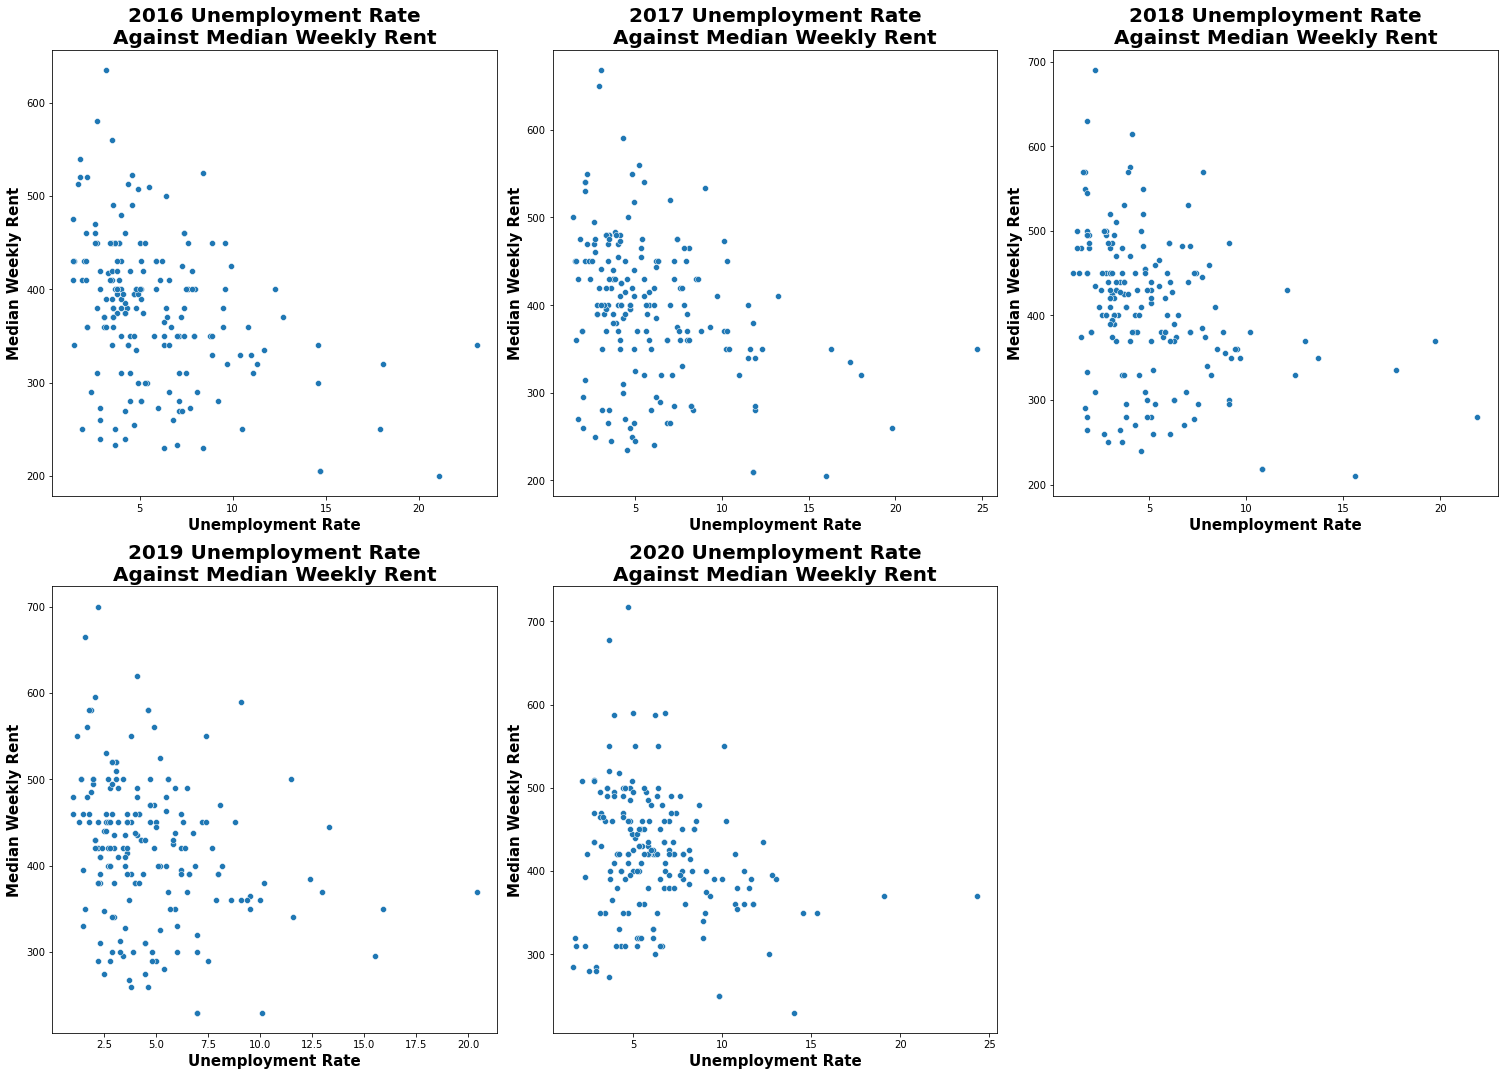

In [36]:
i = 1
plt.figure(figsize=(21,22))

for year in range(2016,2021):
    plt.subplot(3,3,i)
    plt.title(f'{year}')
    
    sns.scatterplot(
        data = historical_rental_and_unemp_w_2021_rental[
            historical_rental_and_unemp_w_2021_rental.year == year
        ],
        
        x='unemp_rate',
        y='Median',
    )
    
    plt.title(f"{year} Unemployment Rate\nAgainst Median Weekly Rent",
             fontsize=20, fontweight="bold")
    
    plt.xlabel("Unemployment Rate", fontsize=15, fontweight="bold")
    plt.ylabel("Median Weekly Rent", fontsize=15, fontweight="bold")
    
    i += 1
    
plt.tight_layout()
plt.savefig('../plots/Unemp_Rate_and_Median_Rent_per_year_no_2021.png',
            transparent=True, facecolor="white", bbox_inches="tight")

# Plot: relationship between unemployment rate and median rental price per region

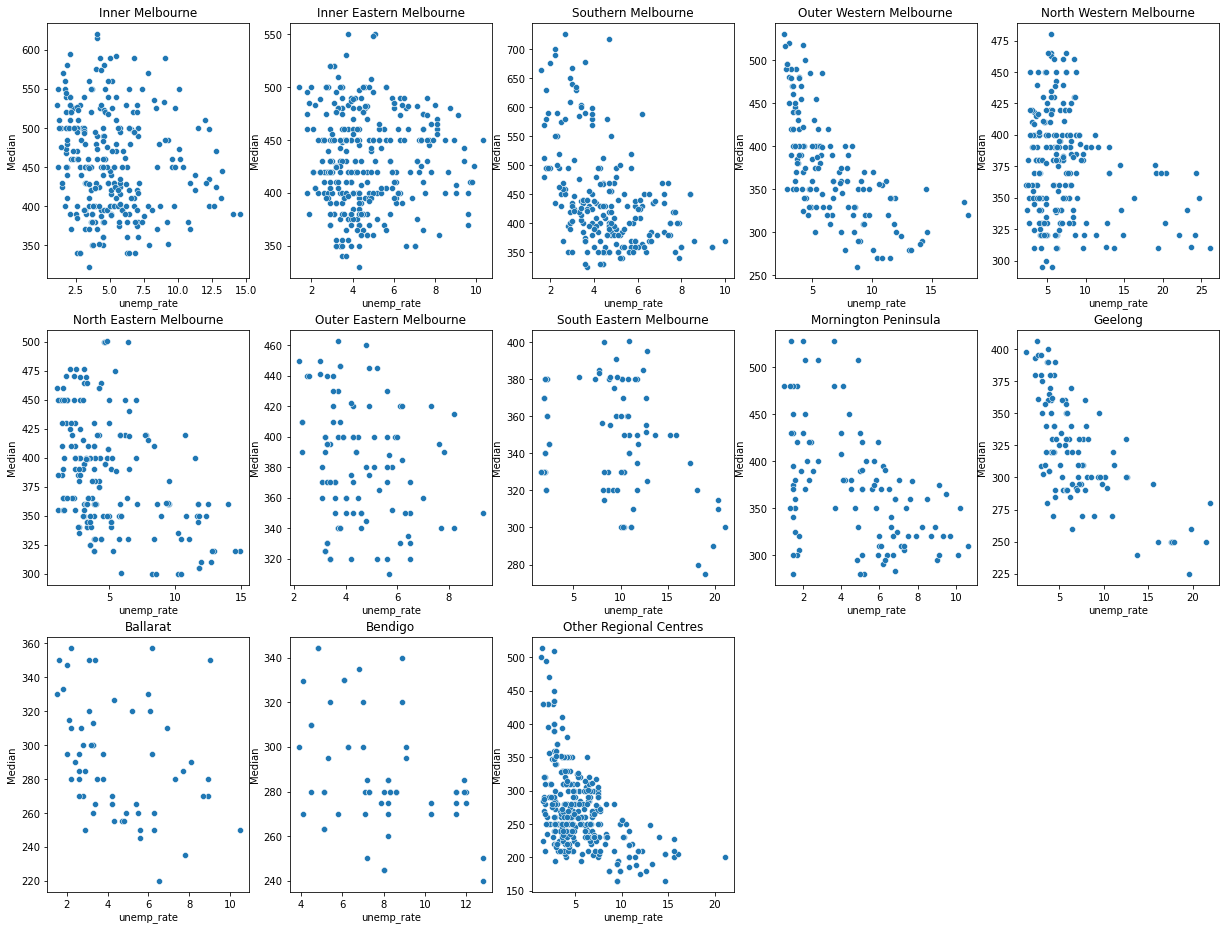

In [37]:
regions = historical_rental_and_unemp_w_2021_rental['Region'].unique()
i = 1
plt.figure(figsize=(21,16))
for region in regions:
    plt.subplot(3,5,i)
    plt.title(f'{region}')
    
    sns.scatterplot(
        data = historical_rental_and_unemp_w_2021_rental[
            historical_rental_and_unemp_w_2021_rental.Region == region
        ],
        
        x='unemp_rate',
        y='Median',
    )
    
    i += 1

# Plot: unemployment rates and rental price overtime by region

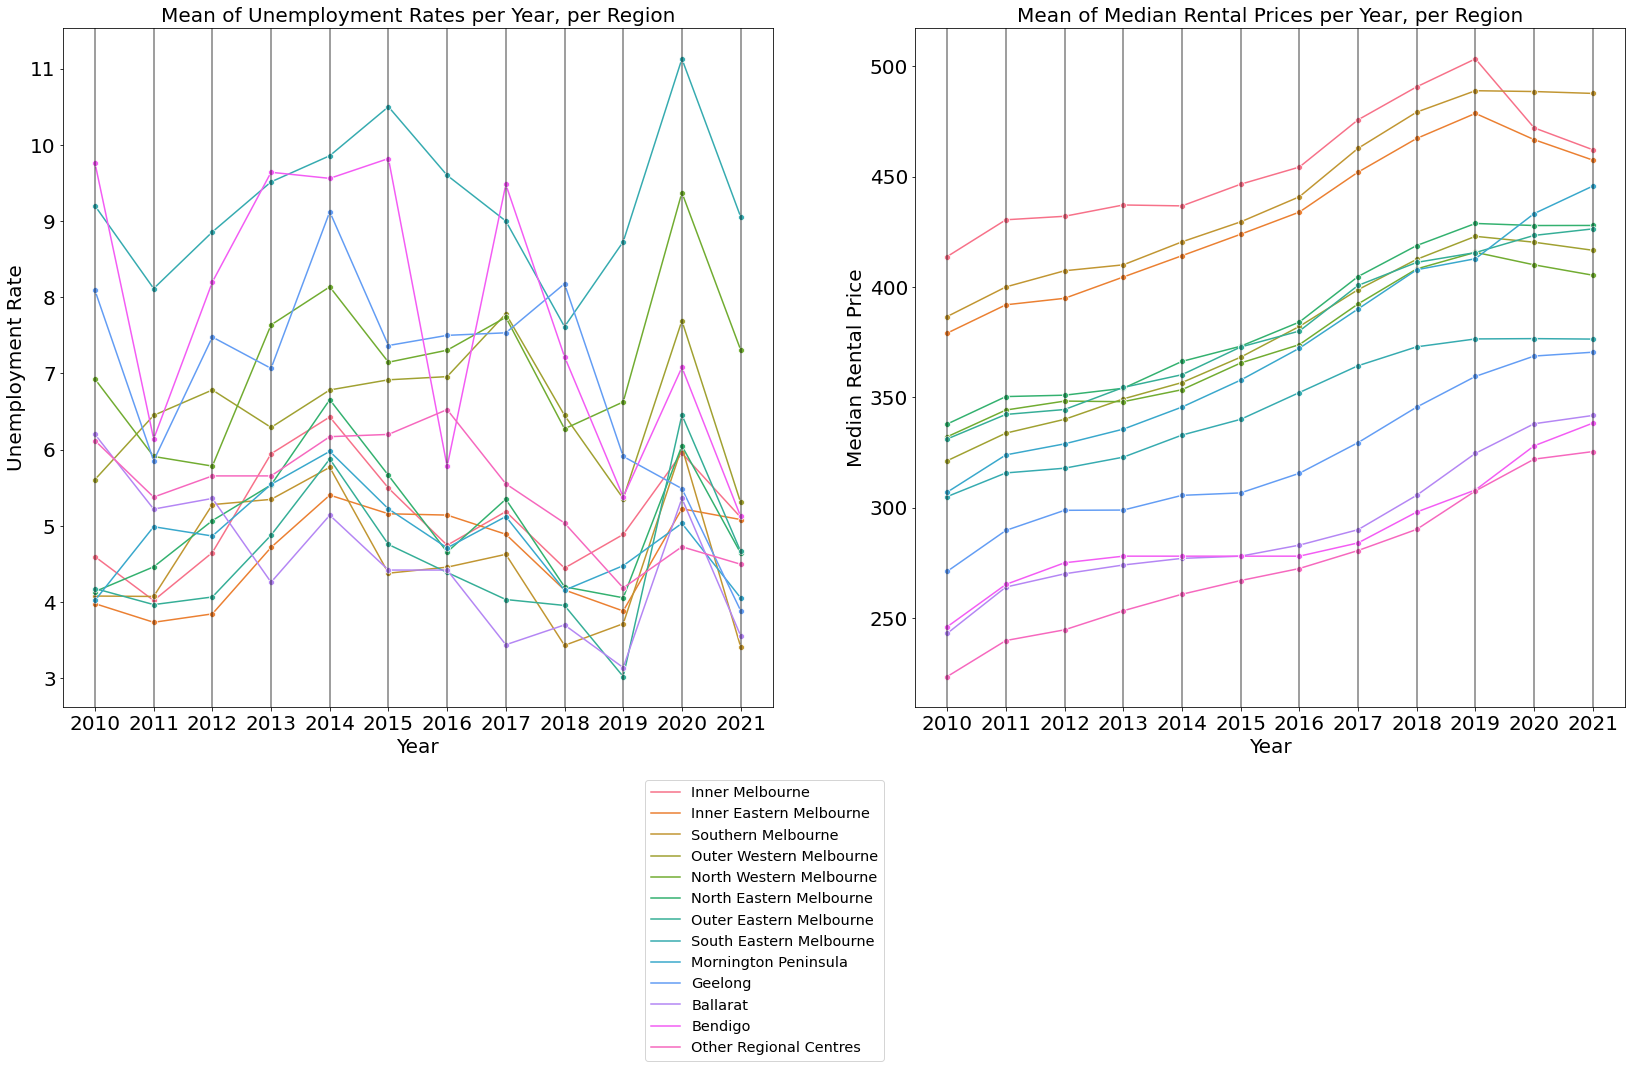

In [38]:
JUMP = 1
FONTSIZE = 20

plt.figure(figsize=(28,12.5))

plt.subplot(1,2,1)


sns.lineplot(data=historical_rental_and_unemp_w_2021_rental,
              x="year",
              y="unemp_rate",
              hue="Region", 
              ci=None,
              marker='o')

#adjusting size of graph for clarity and whatnot 
plt.legend(loc=(0.92-0.1,-0.42-0.1), fontsize=14.5)
plt.xticks(range(2010,2021+1,JUMP), fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.xlabel('Year', fontsize=FONTSIZE)
plt.ylabel('Unemployment Rate', fontsize=FONTSIZE)
plt.title("Mean of Unemployment Rates per Year, per Region",
         fontsize=FONTSIZE)

#add vertical lines in the years to make x-year increase or decrease more 
#for example if x=1 then with the vertical lines we can see ANNUAL decrease
#of the unemployment rate in each region more clearly

for year in range(2010,2021+1,JUMP):
    plt.axvline(x=year,color='black',alpha=0.5)
    


plt.subplot(1,2,2)

sns.lineplot(data=historical_rental_and_unemp_w_2021_rental,
              x="year",
              y="Median",
              hue="Region", 
              ci=None,
              marker='o')

#adjusting size of graph for clarity and whatnot 
plt.legend().remove()
plt.xticks(range(2010,2021+1,JUMP), fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.xlabel('Year', fontsize=FONTSIZE)
plt.ylabel('Median Rental Price', fontsize=FONTSIZE)
plt.title("Mean of Median Rental Prices per Year, per Region",
         fontsize=FONTSIZE)

#add vertical lines in the years to make x-year increase or decrease more 
#for example if x=1 then with the vertical lines we can see ANNUAL decrease
#of the unemployment rate in each region more clearly

for year in range(2010,2021+1,JUMP):
    plt.axvline(x=year,color='black',alpha=0.5)
    
plt.savefig('../plots/Mean_Unemployment_and_Mean_MedianRental_per_year_per_region_subplots.png')

# Plot: mean of unemployment rates and mean of median rental together, per year and per region

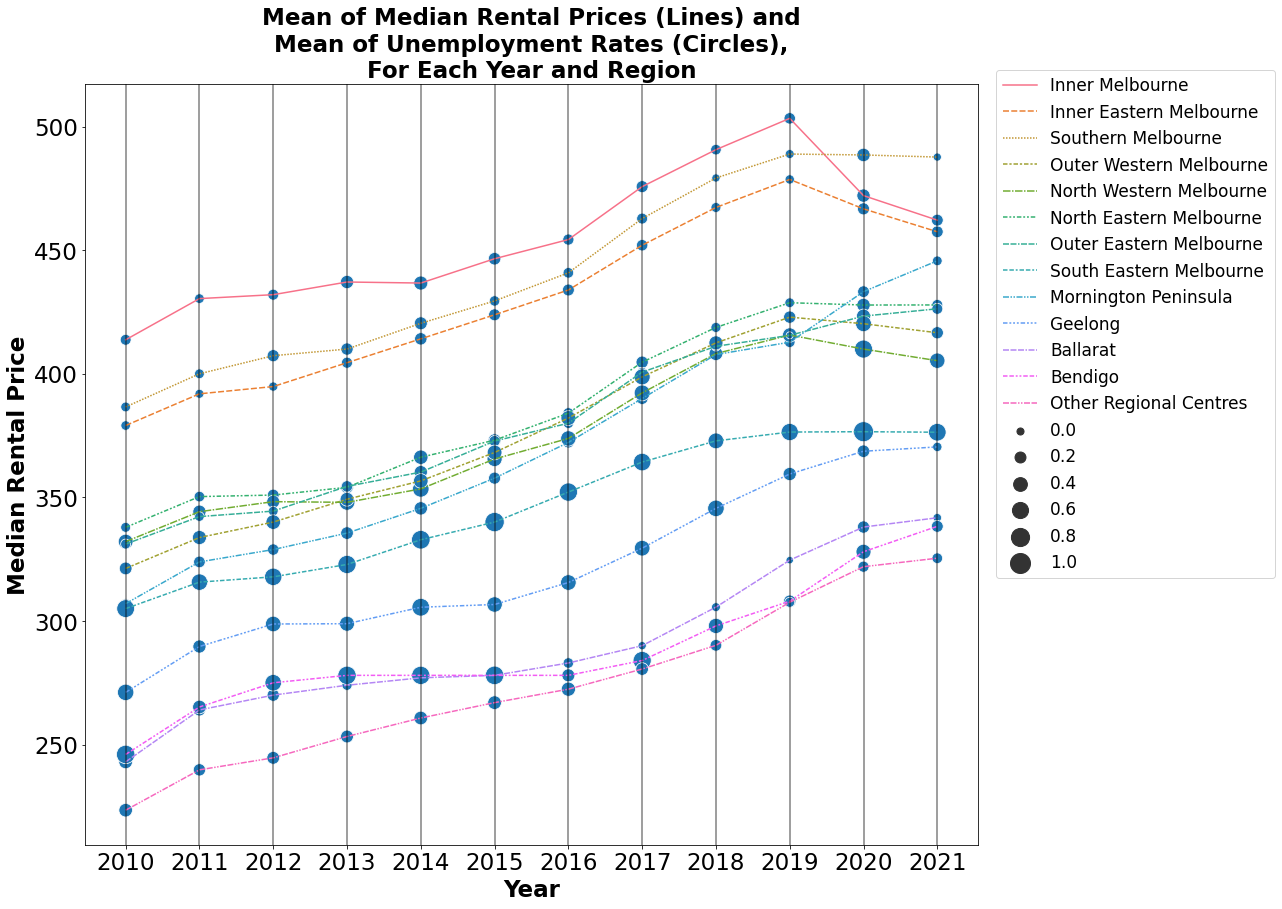

In [39]:
FONTSIZE = 23

plt.figure(figsize=(16,14))

sns.lineplot(data=historical_rental_and_unemp_w_2021_rental,
              x="year",
              y="Median",
              hue="Region",
              style='Region',
              dashes=True,
              ci=None)


mean_unemp_rate_per_region = historical_rental_and_unemp_w_2021_rental.\
                groupby(['year', 'Region']).\
                agg({'Median':'mean','unemp_rate':'mean'}).\
                reset_index()

#normalize the mean unemployment rates per region into 0-1 range 
mean_unemp_rate_per_region['unemp_rate'] =\
        (mean_unemp_rate_per_region['unemp_rate'] - mean_unemp_rate_per_region['unemp_rate'].min()) /\
        (mean_unemp_rate_per_region['unemp_rate'].max() - mean_unemp_rate_per_region['unemp_rate'].min())   


sns.scatterplot(x = 'year', 
                y = 'Median', 
                size = 'unemp_rate', 
                sizes=(50, 400), #force the size of the markers ()
                data = mean_unemp_rate_per_region)
plt.legend('S')


#adjusting size of graph for clarity and whatnot 

plt.legend(loc=(1.02,0.35),fontsize=17)


plt.xticks(range(2010,2021+1,JUMP), fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.xlabel('Year', fontsize=FONTSIZE, fontweight="bold")
plt.ylabel('Median Rental Price', fontsize=FONTSIZE, fontweight="bold")
plt.title("Mean of Median Rental Prices (Lines) and\nMean of Unemployment Rates (Circles),\nFor Each Year and Region",
         fontsize=FONTSIZE, fontweight="bold")

#add vertical lines in the years to make x-year increase or decrease more 
#for example if x=1 then with the vertical lines we can see ANNUAL decrease
#of the unemployment rate in each region more clearly

for year in range(2010,2021+1,JUMP):
    plt.axvline(x=year,color='black',alpha=0.5)
    
    
plt.savefig('../plots/Mean_MedianRental_overlaid_with_Mean_Unemployment_per_year_per_region.png',
            transparent=True, facecolor="white", bbox_inches="tight")
    

# Suburbs with the *highest* average increase of unemployment rate since 2010

Check that each of the suburb has data from exactly 2010 to 2021

In [40]:
unemp_data_all_suburb_melted.groupby('suburb')['year'].nunique().unique()

array([12])

It turns out that there's *still* duplicates of a combination of suburb, year. 
- i.e. Some suburbs have more than 1 unemployment rate for each year. 
- Best to take the mean of such instances.

In [41]:
unemp_data_all_suburb_melted_no_sa2_code = unemp_data_all_suburb_melted.drop(columns='sa2_code')

In [42]:
print(unemp_data_all_suburb_melted_no_sa2_code.shape[0]) 
print(unemp_data_all_suburb_melted_no_sa2_code[['suburb','year']].drop_duplicates().shape[0])

5448
5232


In [43]:
unemp_data_all_suburb_melted_no_sa2_code =\
    unemp_data_all_suburb_melted_no_sa2_code.groupby(['suburb','year'])['unemp_rate'].mean().reset_index()

In [44]:
def add_pct_change(df_suburb):
    df_suburb = df_suburb.sort_values(by='year')
    
    # + 1 to show direct percentage comparison compared to 
    # previous year
    df_suburb['pct_change'] = df_suburb['unemp_rate'].pct_change() + 1
    return df_suburb

unemp_data_all_suburb_melted_w_pct_change = unemp_data_all_suburb_melted_no_sa2_code.groupby('suburb', as_index = False).\
        apply(lambda df_suburb: add_pct_change(df_suburb)).dropna()

suburbs_and_unemp_pct_change = unemp_data_all_suburb_melted_w_pct_change.groupby('suburb')['pct_change'].mean().reset_index()

In [45]:
def generate_barplot(data, title, e=0.01):
    
    plt.figure(figsize=(15, 15)) 
    
    fig = sns.barplot(x = 'suburb', 
                      y = 'pct_change', 
                      data = data, 
                      palette = 'mako' ,  
                      dodge=False,
                     )
    
    data['pct_change'] = round(data['pct_change'],4)
    
    
    fig.set(ylim=(data['pct_change'].min() - e, 
                  data['pct_change'].max() + e))
    
    fig.bar_label(fig.containers[-1], size=22)
    
    #fig.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1,  prop={'size': 20})
    

    fig.set_ylabel('Average Year on Year Change (%)', size = 25)
    fig.set_xlabel('Suburb', size = 25)

    #fig.set_yticklabels(size = 20)
    fig.yaxis.set_tick_params(labelsize = 25)
    
    fig.set_xticklabels([i for i in data['suburb']], size = 17, rotation = 90)
    
    #fig.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    
    fig.set_title(title, size = 33)
    
    
    

In [46]:
unemp_ten_lowest = suburbs_and_unemp_pct_change.sort_values(by='pct_change',ascending=True).head(10)
unemp_ten_highest = suburbs_and_unemp_pct_change.sort_values(by='pct_change',ascending=False).head(10)

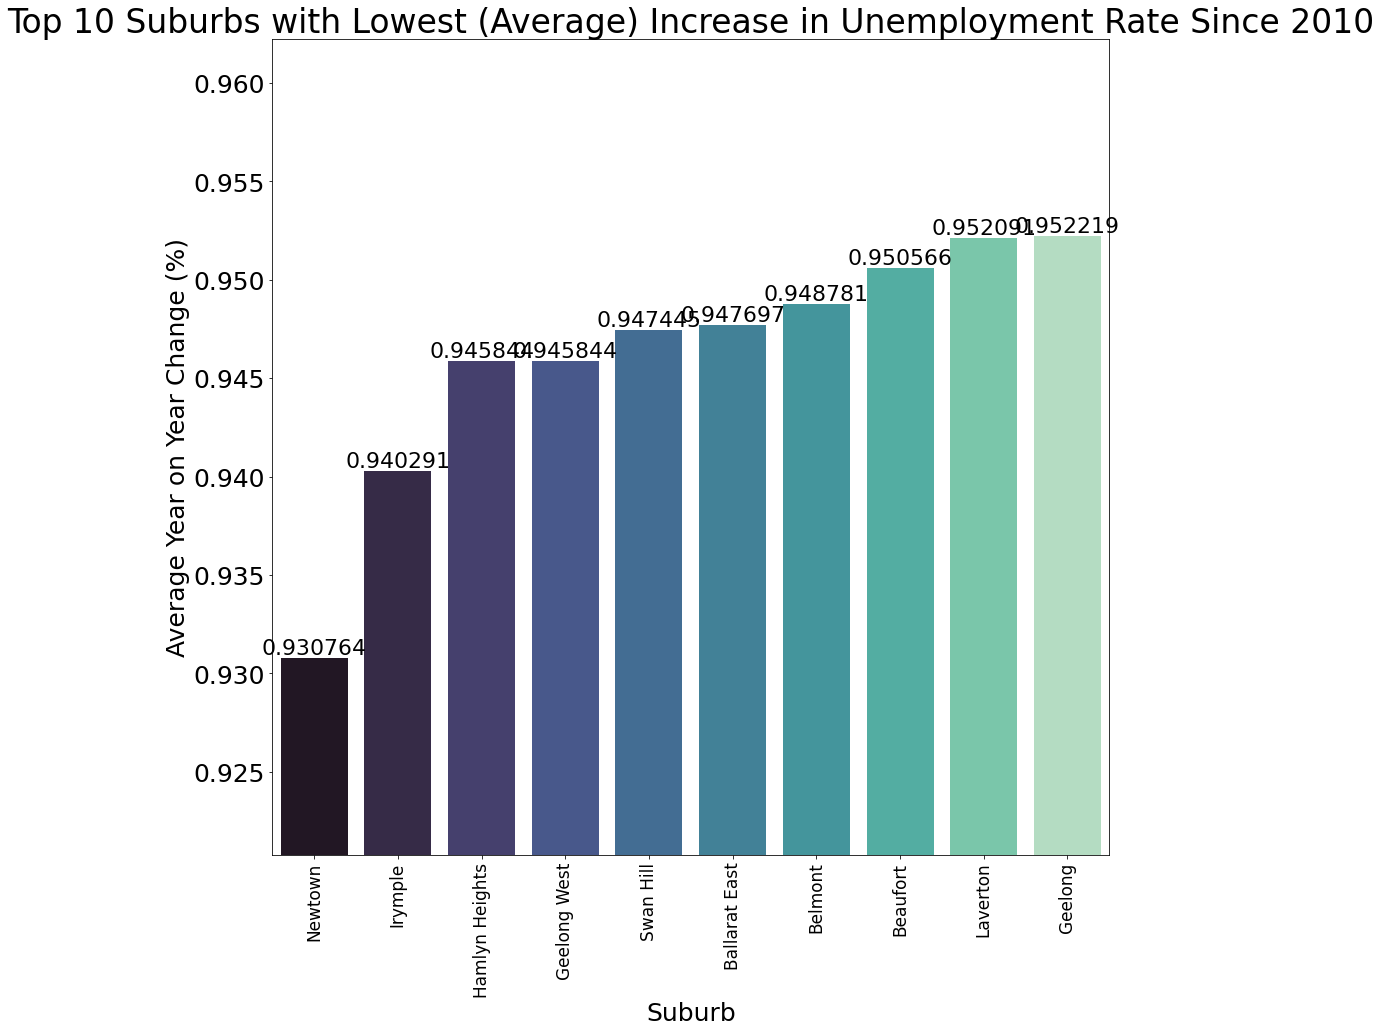

In [47]:
unemp_ten_lowest['suburb'] = unemp_ten_lowest['suburb'].str.title()
generate_barplot(unemp_ten_lowest,
                'Top 10 Suburbs with Lowest (Average) Increase in Unemployment Rate Since 2010')

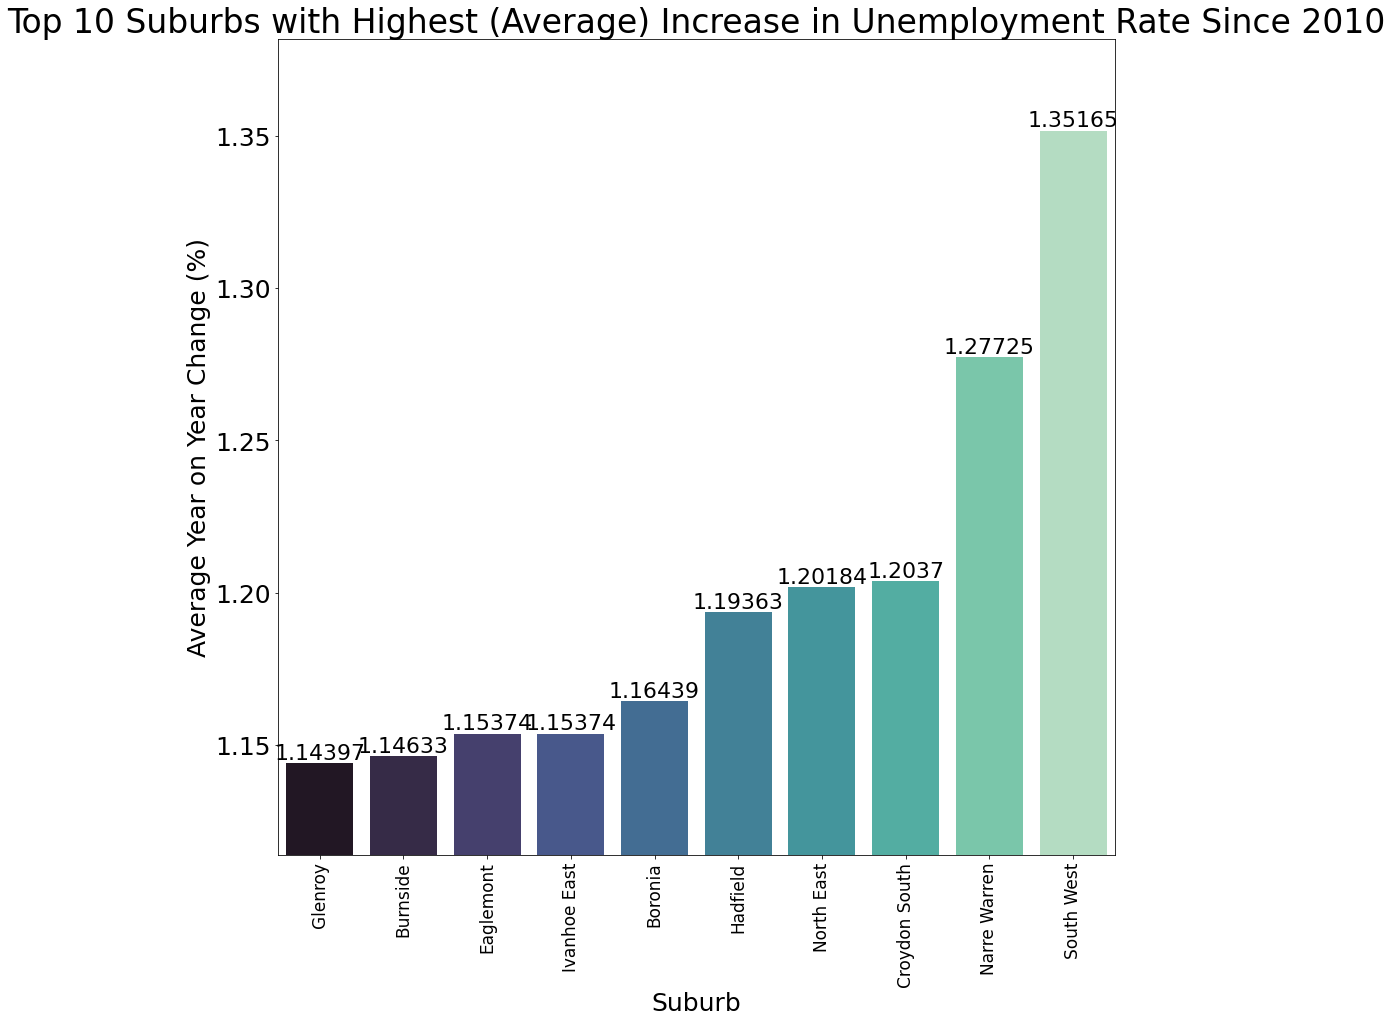

In [48]:
unemp_ten_highest['suburb'] = unemp_ten_highest['suburb'].str.title()
unemp_ten_highest = unemp_ten_highest.sort_values(by='pct_change')
generate_barplot(unemp_ten_highest,
                'Top 10 Suburbs with Highest (Average) Increase in Unemployment Rate Since 2010',
                e=0.03)

Later can experiment: lineplot unemployment rates, and use markers for rentla prices

In [49]:
# had an idea of parallel coordinates but won't be too suitable since there are many regions

# hist_rental_and_ump_w_region = historical_rental_and_unemp_w_2021_rental[['unemp_rate', 'Median','Region']].copy()

# #scaling them into 0-1 range to be comparable in PC
# unemp_rate_min = hist_rental_and_ump_w_region['unemp_rate'].min()
# unemp_rate_max = hist_rental_and_ump_w_region['unemp_rate'].max()
# unemp_rate_range = unemp_rate_max - unemp_rate_min

# Median_rent_min = hist_rental_and_ump_w_region['Median'].min()
# Median_rent_max = hist_rental_and_ump_w_region['Median'].max()
# Median_rent_range = Median_rent_max - Median_rent_min


# hist_rental_and_ump_w_region['unemp_rate'] =\
#         (hist_rental_and_ump_w_region['unemp_rate'] - unemp_rate_min)/unemp_rate_range

# hist_rental_and_ump_w_region['Median'] =\
#         (hist_rental_and_ump_w_region['Median'] - Median_rent_min)/Median_rent_range


# hist_rental_and_ump_w_region =\
#     hist_rental_and_ump_w_region.rename(columns={'unemp_rate':'Unemployment Rate',
#                                                  'Median':'Median Rental Price'})


# #plot parallel coordinates
# plt.figure(figsize=(17,10.5))
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)

# parallel_coordinates(
#     hist_rental_and_ump_w_region, 
#     'Region',
#     sort_labels=True,
#     alpha=0.5
# )

# plt.legend(loc=(1.06,0.2),fontsize=12)

# Save the preprocessed historical rental file and final preprocessed unemployment melted data!

In [50]:
rental_data_all_suburb_with_2021.to_csv('../data/curated/Fixed_Weekly_Median_Suburb_Rents.csv')

In [51]:
unemp_data_all_suburb_melted.to_csv('../data/curated/Final_preprocesed_unemployment_melted.csv')

In [52]:
unemp_data_all_suburb_melted

suburb     sa2_code  unemp_rate  year
0             alfredton  201011001.0         2.9  2010
1         ballarat east  201011002.0         7.8  2010
2             buninyong  201011005.0         3.3  2010
3             delacombe  201011006.0         6.5  2010
4         smythes creek  201011007.0         3.6  2010
...                 ...          ...         ...   ...
21190  california gully  202011019.0         6.2  2021
21191            clunes  201021010.0         3.7  2021
21192          creswick  201021010.0         3.7  2021
21193       miners rest  201011008.0         6.2  2021
21194         wendouree  201011008.0         6.2  2021

[5448 rows x 4 columns]